In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gzip
import pickle

from IPython.display import display

plt.style.use(".mplstyle")
pd.set_option("display.max_rows", 25)
pd.set_option("display.max_colwidth", 0)


In [14]:
BASE_DIR = "./Synth/synth_data_synth_07_27"
METRICS_DIR = os.path.join(BASE_DIR, "metrics/")


In [19]:
def metrics_to_df(results, metrics=["precision", "recall", "mrr"]):
    data = []

    for method in ("bm25plus", "random"):
        for eval_type in ("collapse",):
            if eval_type != "collapse":
                current_metrics = metrics + ["mrr_compare_fn_subject", "mrr_compare_fn_object", "mrr_compare_fn_relation"]
            else:
                current_metrics = metrics
            for metric in current_metrics:
                metric_result = results["evals"][method][eval_type][metric]
                for normalized in ("cosine", "dot"):
                    for method_type in ("local", "global"):
                        try:
                            for k, score in metric_result.items():
                                data.append(
                                    (
                                        method,
                                        method_type,
                                        normalized,
                                        eval_type,
                                        metric,
                                        str(k),
                                        score,
                                    )
                                )
                        except:
                            data.append(
                                (
                                    method,
                                    method_type,
                                    normalized,
                                    eval_type,
                                    metric,
                                    "1",
                                    metric_result,
                                )
                            )

    for method_type in ("local", "global"):
        for eval_type in ("collapse", ):
            for normalized in ("cosine", "dot"):
                if method_type == "global" and normalized == "dot":
                    continue
                for method, method_results in results["evals"][method_type][
                    normalized
                ][eval_type].items():
                    if eval_type != "collapse":
                        current_metrics = metrics + ["mrr_compare_fn_subject", "mrr_compare_fn_object", "mrr_compare_fn_relation"]
                    else:
                        current_metrics = metrics
                    for metric in current_metrics:
                        metric_result = method_results[metric]
                        try:
                            for k, score in metric_result.items():
                                data.append(
                                    (
                                        method,
                                        method_type,
                                        normalized,
                                        eval_type,
                                        metric,
                                        str(k),
                                        score,
                                    )
                                )
                        except:
                            data.append(
                                (
                                    method,
                                    method_type,
                                    normalized,
                                    eval_type,
                                    metric,
                                    "1",
                                    metric_result,
                                )
                            )

    df = pd.DataFrame(
        data,
        columns=[
            "layers",
            "norm_type",
            "normalization",
            "eval",
            "metrics",
            "k",
            "score",
        ],
    )

    df["layer_type"] = "Embed"
    df.loc[df["layers"].str.contains("gradients"), "layer_type"] = "TracIn"
    df.loc[
        (df["layers"].str.contains("gradients"))
        & (df["layers"].str.contains("activations")),
        "layer_type",
    ] = "TracIn+Embed"
    df.loc[
        (df["layers"] == "random") | (df["layers"] == "bm25plus"), "layer_type"
    ] = "baselines"

    df = df.replace(
        {
            "gradients": "G",
            "activations": "A",
            "block.": "",
            "encoder": "E",
            "decoder": "D",
            "shared": "emb",
            "random": "Target-Picker",
        },
        regex=True,
    )

    df["layers"] = (
        df["layers"]
        .replace(
            {f"G.E.{i},G.D.{i}": f"G.E.{i+1},G.D.{i+1}" for i in range(12)},
            regex=False,
        )
        .replace({f"G.E.{i}": f"G.E.{i+1}" for i in range(12)}, regex=False)
        .replace(
            {
                f"G.emb,G.E.{i},G.D.{i}": f"G.emb,G.E.{i+1},G.D.{i+1}"
                for i in range(12)
            },
            regex=False,
        )
        .replace(
            {f"G.emb,G.E.{i}": f"G.emb,G.E.{i+1}" for i in range(12)},
            regex=False,
        )
        .str.replace("G.emb", "G.0", regex=False)
        .str.replace("bm25plus", "BM25+", regex=False)
        .str.replace("Target-Picker", "Random-Target", regex=False)
    )

    return df


In [20]:
def plot_with_filter(df, 
                     filter=lambda x: x,
                     title="Title",
                     folder="plots/",
                     ylabel='',
                     save=False):
    plt.figure(figsize=(16, 6))
    
    ax = sns.barplot(data=filter(df), 
                     x='layers', 
                     y='score', 
                     hue='layer_type', 
                     estimator=np.mean, 
                     ci='sd')
    
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel("Layer Selection")
    plt.ylabel(ylabel)
    plt.legend(title='Method Type')
    
    if not save:
        plt.show()
    else:
        plt.savefig(folder+title+"_plot.png")
        plt.show()

In [24]:
def visualize_one_experiment(
    paths,
    suffix="",
    folder="plots/",
    save=False,
    visualize=False,
    k="3",
    norm_type="local",
    normalization="cosine",
):
    dfs = []
    for (i, path) in enumerate(paths):

        with gzip.open(METRICS_DIR + path) as f:
            reranker_metrics = pickle.load(f)

        df = metrics_to_df(reranker_metrics)
        df["seed"] = i
        dfs.append(df)

    df = pd.concat(dfs, ignore_index=True)

    if visualize:

        # scores = df.groupby(['normalization', 'eval', 'layers', 'metrics', 'k']).agg({'score': ['mean', 'std']}, as_index=False)
        # Layers that we don't want for visualizations
        ddf = df[~df["layers"].str.contains("A.E.0,A.D.0,")]

        for method in ("collapse", ):
            plot_with_filter(
                ddf,
                filter=lambda x: x[
                    (x["metrics"] == "precision")
                    & (x["k"] == '3')
                    & (x["eval"] == method)
                    & (x["norm_type"] == norm_type)
                    & (x["normalization"] == normalization)
                ],
                title=f"precision@3 ({method} + {suffix})",
                folder=folder,
                ylabel="precision@3",
                save=save,
            )

            plot_with_filter(
                ddf,
                filter=lambda x: x[
                    (x["metrics"] == "recall")
                    & (x["k"] == '10')
                    & (x["eval"] == method)
                    & (x["norm_type"] == norm_type)
                    & (x["normalization"] == normalization)
                ],
                title=f"recall@10 ({method} + {suffix})",
                folder=folder,
                ylabel="recall@10",
                save=save,
            )

            plot_with_filter(
                ddf,
                filter=lambda x: x[
                    (x["metrics"] == "mrr")
                    & (x["k"] == "1")
                    & (x["eval"] == method)
                    & (x["norm_type"] == norm_type)
                    & (x["normalization"] == normalization)
                ],
                title=f"mrr ({method} + {suffix})",
                folder=folder,
                ylabel="mrr",
                save=save,
            )
    return df


In [7]:
def get_abstracts_df(res, fact):
    abstracts = np.array(res["nn_abstracts"])
    for i, abstract in enumerate(abstracts):
        try:
            abstract["score"] = res["nn_scores"][i]
        except KeyError:
            abstract["score"] = res["nn"]["scores"][i]

    df = pd.DataFrame(pd.json_normalize(abstracts)).round(3)
    df["label"] = df["facts"].str.contains(",".join(fact))

    df = df.drop(
        ["page_uri", "masked_uri", "masked_type", "facts", "example_uris"],
        axis=1,
    )
    return df


def get_nn_abstracts(res, baseline_res, config=""):
    """Get list of abstracts and their scores (dotproduct score)"""
    print(f"Config: {config}")
    example = baseline_res["example"]
    print(
        f"Example: {example['inputs_pretokenized']} =>"
        f" {example['targets_pretokenized']}"
    )
    fact = (
        # example["predicate_id"].strip(),
        # example["obj_uri"].strip(),
        # example["sub_uri"].strip(),
        example["uuid"]
    )
    print(f"Fact: {fact}")
    print(f"Model Precision", res["precision"])
    df_model = get_abstracts_df(res, fact)
    print(f"Baseline Precision", baseline_res["precision"])
    df_baseline = get_abstracts_df(baseline_res, fact)
    return df_model, df_baseline


def result_getter(path):
    with gzip.open(METRICS_DIR + path) as f:
        reranker_metrics = pickle.load(f)

    def getter(
        i=3,
        sim="cosine",
        method="collapse",
        normalization="local",
        layers="activations.encoder.block.0,gradients.shared",
    ):

        config = {
            "sim": sim,
            "method": method,
            "layers": layers,
            "normalization": normalization,
        }

        return get_nn_abstracts(
            reranker_metrics["evals"][normalization][sim][method][layers][
                "samples"
            ][i],
            reranker_metrics["samples"][i],
            config=config,
        )

    getter.metrics = reranker_metrics
    return getter


In [9]:
os.getcwd()

'/raid/lingo/akyurek/gitother/fewshot_lama'

In [26]:
getter = result_getter('reranker/sweep/seed_0/learned/no_eos_accum/results_detailed.pickle')

In [17]:
idx = 10
tracin_res, baseline_res = getter(i=idx, layers='gradients.shared')
embed_res,_= getter(i=idx, layers='activations.encoder.block.0,activations.decoder.block.0')

Config: {'sim': 'cosine', 'method': 'collapse', 'layers': 'gradients.shared', 'normalization': 'local'}
Example: entity-DCCX's profession is <extra_id_0> => <extra_id_0> entity-MMCLXX


KeyError: 'predicate_id'

In [12]:
baseline_res

NameError: name 'baseline_res' is not defined

In [13]:
tracin_res

NameError: name 'tracin_res' is not defined

In [14]:
def process(model_res):
    model_res['text'] = '\\textbf{Q:} ' + model_res['inputs_pretokenized'].str.replace('<extra_id_0>', '[MASK]') +  ' \\newline\\textbf{A:} ' + model_res['targets_pretokenized'].str.replace('<extra_id_0>', '') + ' \\textbf{' +  model_res['label'].astype(str) + '}'
    return model_res.head(3)    

In [15]:
print("\\\\ \n  \\midrule \n".join(process(tracin_res)['text'] + '&' + process(embed_res)['text'] +  '&' + process(baseline_res)['text'] ) + ' \\ \n')


NameError: name 'tracin_res' is not defined

In [16]:


print("Model Table")
display(model_res)
print("Baseline Table")
display(baseline_res)

Model Table


NameError: name 'model_res' is not defined

In [17]:
model_res, baseline_res = getter(i=3, layers='activations.encoder.block.0,activations.decoder.block.0')
print("Model Table")
display(model_res)
print("Baseline Table")
display(baseline_res)

NameError: name 'getter' is not defined

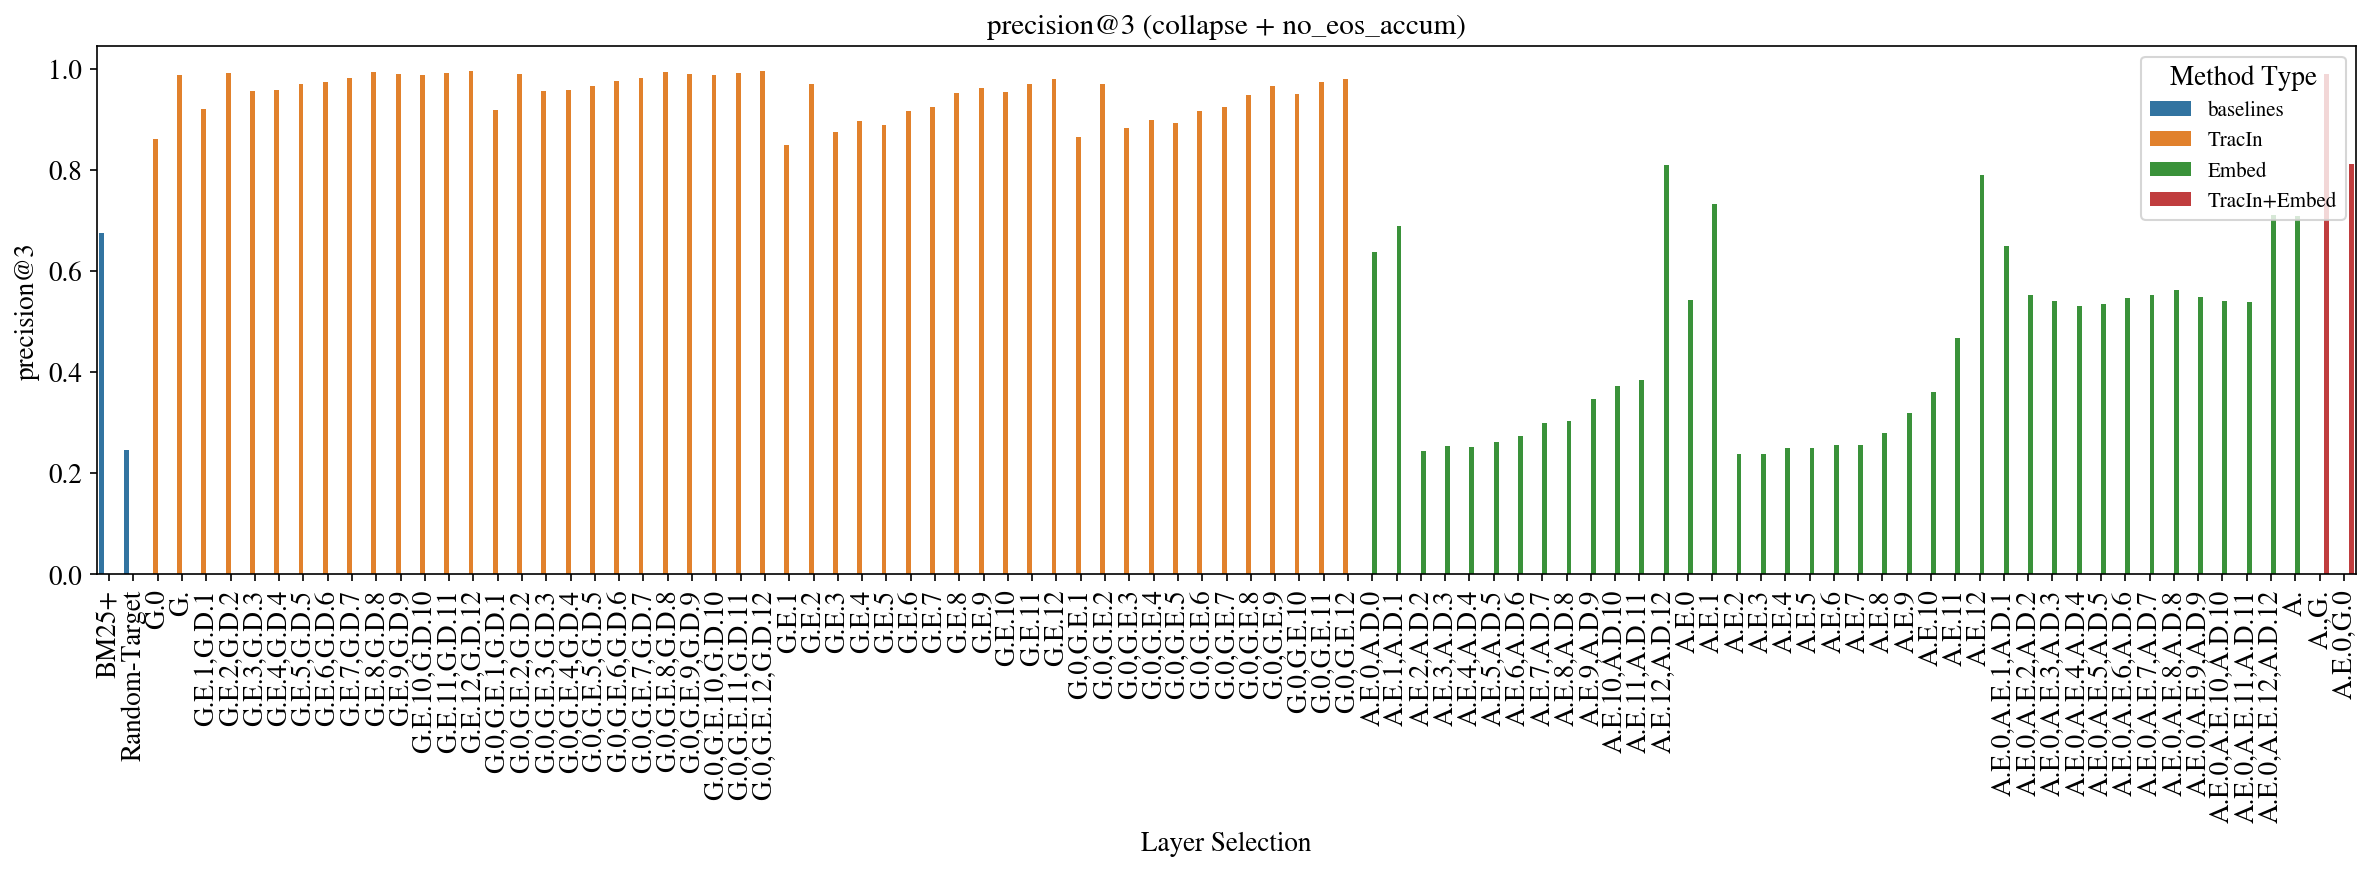

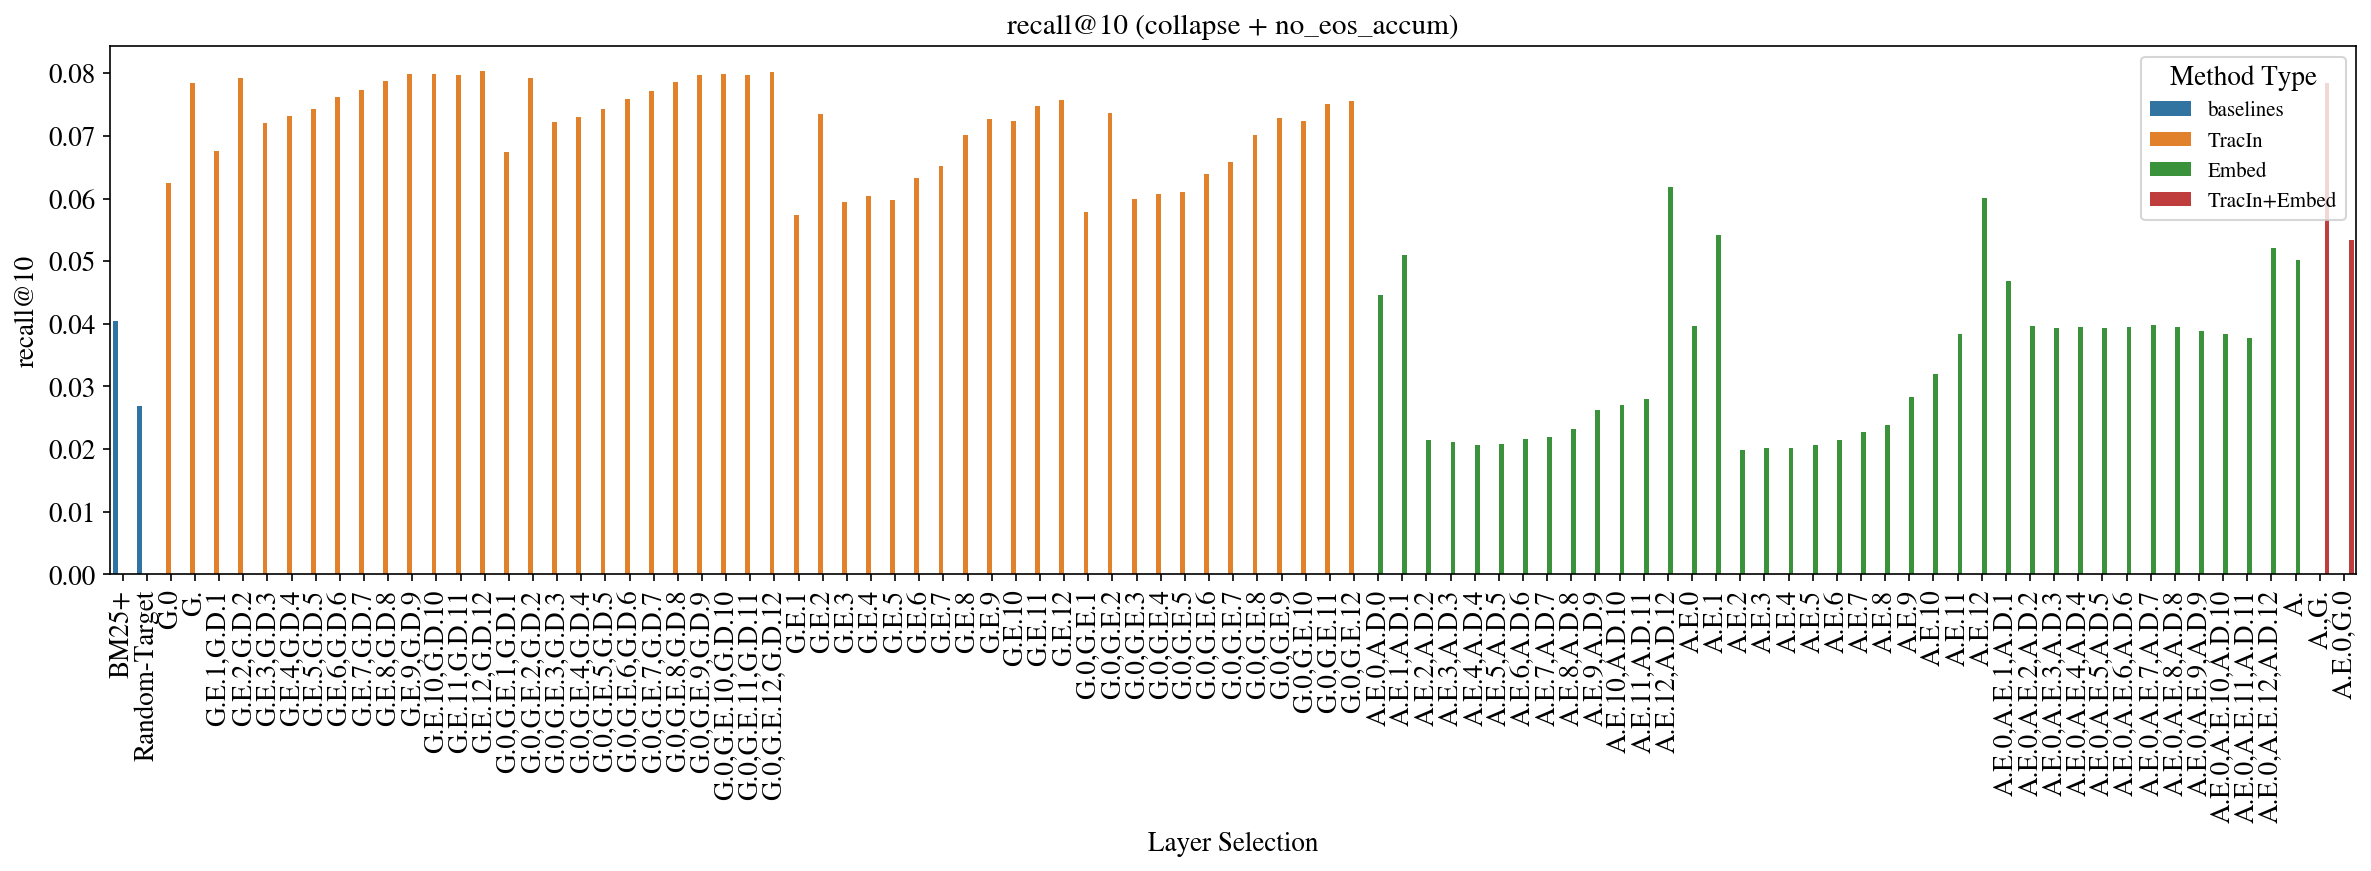

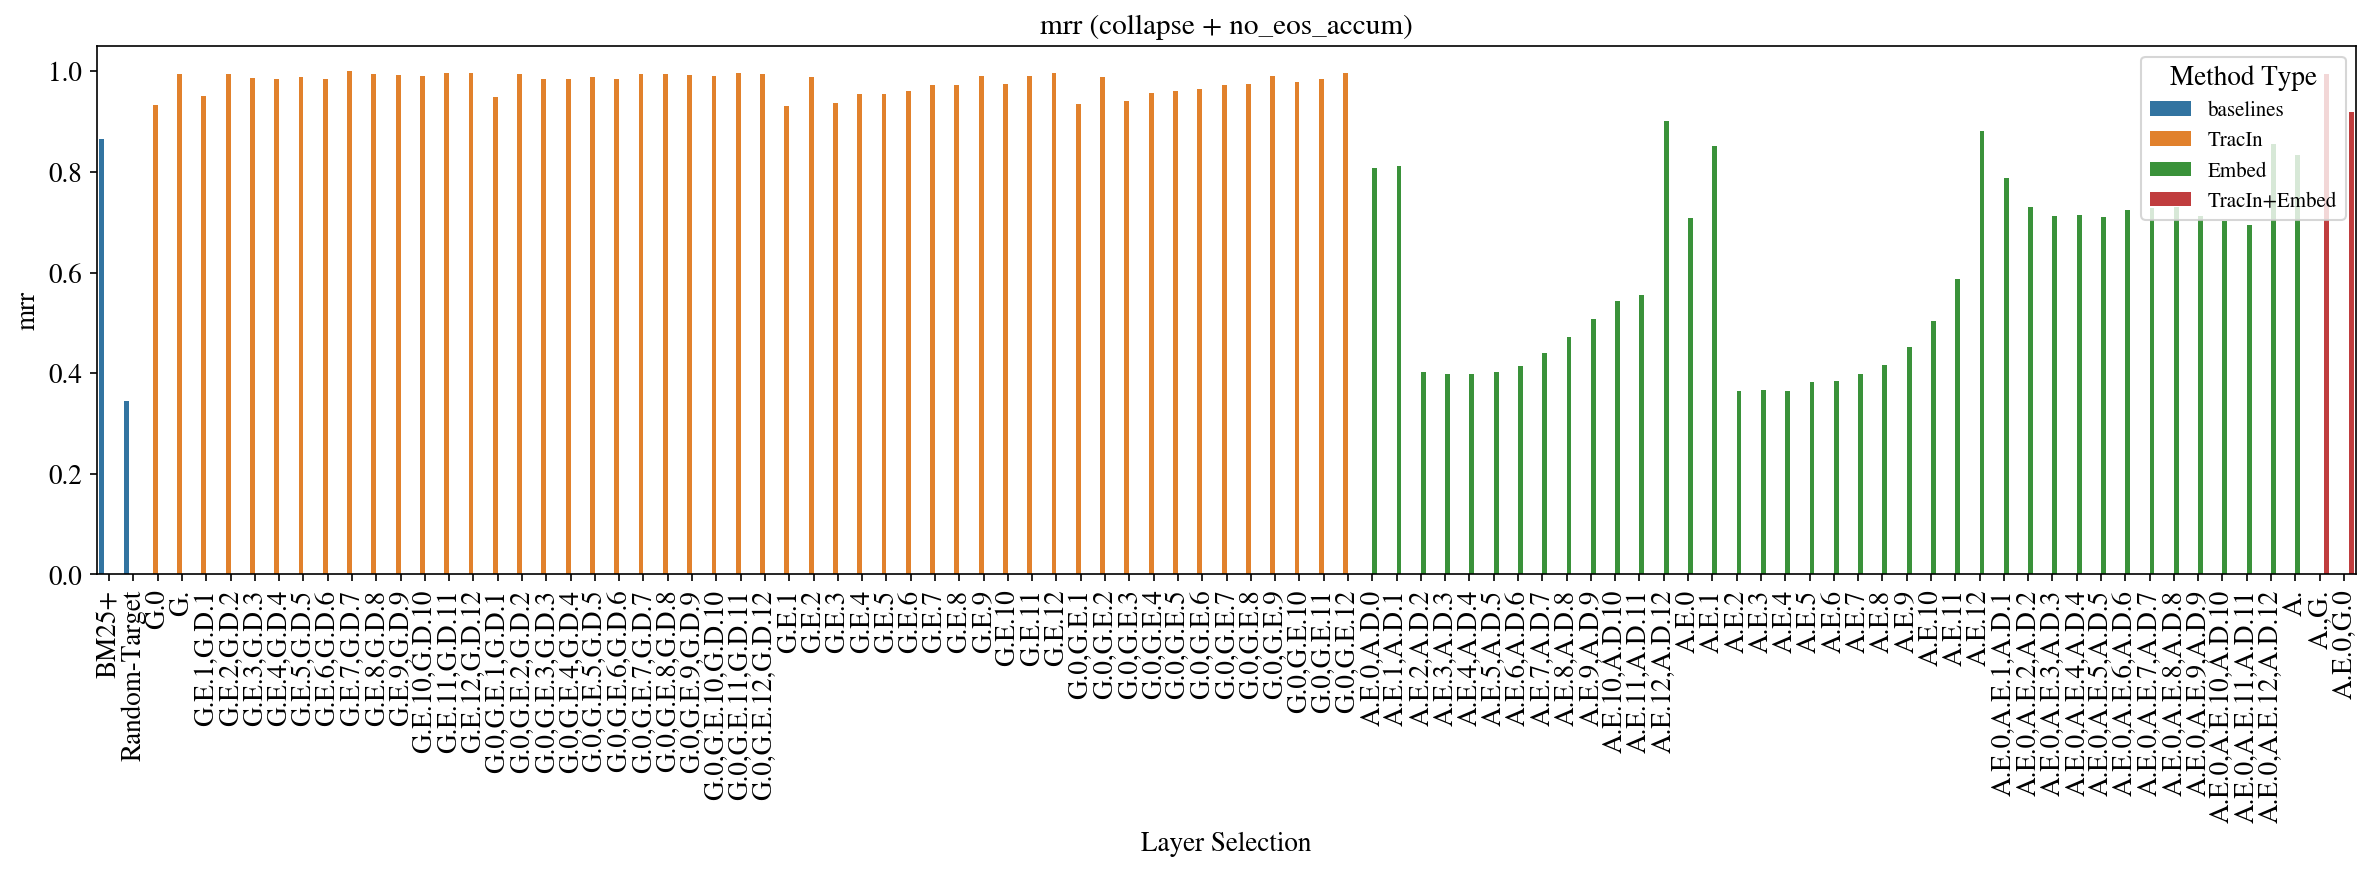

In [25]:
df = visualize_one_experiment(
    paths=[
        f"reranker/sweep/seed_{i}/learned/no_eos_accum/results_detailed.pickle"
        for i in range(1)
    ],
    suffix="no_eos_accum",
    save=True,
    visualize=True,
)


In [ ]:
dfs = {}
for eos in ("no_eos", ):
    for subset in ("learned",):
        for accum in ("no_accum", "accum"):
            try:
                suffix = f"{eos}+{subset}+{accum}"
                df = visualize_one_experiment(
                    paths=[
                        f"reranker/sweep_v2/seed_{i}/{subset}/{eos}_{accum}/results_detailed.pickle"
                        for i in range(3)
                    ],
                    suffix=suffix,
                    save=False,
                    visualize=False,
                )
                df["eos"] = eos
                df["subset"] = subset
                df["accum"] = accum
                dfs[suffix] = df
            except FileNotFoundError:
                print(
                    "Couldn't find: "
                    f"reranker/sweep_v2/seed_0/{subset}/{eos}_{accum}/results_detailed.pickle"
                )


In [ ]:
dfmerged = pd.concat(list(dfs.values()), ignore_index=True)

In [ ]:
scores = dfmerged.groupby([column for column in dfmerged.columns if column != 'seed' and column != 'score'], axis=0).agg({'score': [np.mean, np.std]}, as_index=False)
scores = scores.reset_index()
    

In [14]:
def get_max(df: pd.DataFrame, 
            prefix, 
            no_prefix=None, 
            subset='learned', 
            metric='mrr', 
            eval_type='collapse', 
            k='1'):
    
    df2 = df[(df['layers'].str.startswith(prefix)) & 
             (df['subset'] == subset) &
             (df['metrics'] == metric) &
             (df['k'] == str(k)) &
             (df['eval'] == eval_type)]
    
    if no_prefix:
        df2 = df2[~df2['layers'].str.contains(no_prefix)]
        
    nlargest = df2.nlargest(10, ('score', 'mean'))
    
    largest = nlargest.iloc[0]    
    dflargest = df[(df['layers'] == largest['layers'][0]) &
                   (df['norm_type'] == largest['norm_type'][0]) &
                   (df['eos'] == largest['eos'][0]) &
                   (df['accum'] == largest['accum'][0]) &
                   (df['subset'] == subset)]# &
#                   (df['eval'] == eval_type)]

    dflargest = dflargest.set_index('metrics').loc[['mrr', 'mrr_compare_fn_relation', 'mrr_compare_fn_subject', 'mrr_compare_fn_object', 'recall']]
    dflargest['score_text'] = (100 * dflargest['score']['mean']).apply(lambda x: f"{x:.2f}") + '\stderr{' + (100 * dflargest['score']['std']).apply(lambda x: f"{x:.2f}") + '}'
    dflargest = dflargest.transpose()
    dflargest = dflargest.loc[['score_text', 'k', 'eval']]
    return nlargest, dflargest


In [ ]:
largest, dflargest = get_max(scores, 'A', no_prefix='G')
display(largest)
display(dflargest)


In [ ]:
largest, dflargest = get_max(scores, 'A')
display(largest)
display(dflargest)

In [ ]:
largest, dflargest = get_max(scores, 'G')
display(largest)
display(dflargest)

In [ ]:
largest, dflargest = get_max(scores, 'BM25+')
display(largest)
display(dflargest)

In [ ]:
largest, dflargest  = get_max(scores, 'Random-Target')
display(largest)
display(dflargest)

In [ ]:
dfs = {}
for eos in ("no_eos", "eos"):
    for subset in ("learned",):
        for accum in ("no_accum", "accum"):
            try:
                suffix = f"{eos}+{subset}+{accum}"
                df = visualize_one_experiment(
                    paths=[
                        f"reranker/sweep_v2/seed_{i}/{subset}/{eos}_{accum}/results_detailed.pickle"
                        for i in range(3)
                    ],
                    suffix=suffix,
                    save=False,
                    visualize=False,
                )
                df["eos"] = eos
                df["subset"] = subset
                df["accum"] = accum
                dfs[suffix] = df
            except FileNotFoundError:
                print(
                    "Couldn't find: "
                    f"reranker/sweep_v2/seed_0/{subset}/{eos}_{accum}/results_detailed.pickle"
                )


In [ ]:
dfmerged = pd.concat(list(dfs.values()), ignore_index=True)
scores = dfmerged.groupby([column for column in dfmerged.columns if column != 'seed' and column != 'score'], axis=0).agg({'score': [np.mean, np.std]}, as_index=False)
scores = scores.reset_index()
df = scores

In [ ]:
dflargest = df[(df['layers'] == 'G.0') &
               (df['subset'] == 'learned') &
               ((df['metrics'] == 'mrr')) &
               (df['eval'] == 'collapse')]
dflargest['score_text'] = (100 * dflargest['score']['mean']).apply(lambda x: f"{x:.2f}") + '\stderr{' + (100 * dflargest['score']['std']).apply(lambda x: f"{x:.2f}") + '}'
dflargest

In [ ]:
dflargest = df[(df['layers'] == 'G.0') &
               (df['subset'] == 'learned') &
               ((df['metrics'] == 'recall')) &
                ((df['k'] == '10')) &
               (df['eval'] == 'collapse')]
dflargest['score_text'] = (100 * dflargest['score']['mean']).apply(lambda x: f"{x:.2f}") + '\stderr{' + (100 * dflargest['score']['std']).apply(lambda x: f"{x:.2f}") + '}'
dflargest

In [9]:
dfs = {}
for eos in ("no_eos", ):
    for subset in ("random", ):
        for accum in ("no_accum", ):
            try:
                suffix = f"{eos}+{subset}+{accum}"
                df = visualize_one_experiment(
                    paths=[
                        f"reranker/sweep_v2_ft_pt/seed_{i}/{subset}/{eos}_{accum}/results_detailed.pickle"
                        for i in range(3)
                    ],
                    suffix=suffix,
                    save=False,
                    visualize=False,
                )
                df["eos"] = eos
                df["subset"] = subset
                df["accum"] = accum
                dfs[suffix] = df
            except FileNotFoundError:
                print(
                    "Couldn't find: "
                    f"reranker/sweep_v2/seed_0/{subset}/{eos}_{accum}/results_detailed.pickle"
                )

In [15]:
dfmerged = pd.concat(list(dfs.values()), ignore_index=True)
scores = dfmerged.groupby([column for column in dfmerged.columns if column != 'seed' and column != 'score'], axis=0).agg({'score': [np.mean, np.std]}, as_index=False)
scores = scores.reset_index()

In [19]:
largest, dflargest = get_max(scores, 'G', subset='random')
display(largest)
display(dflargest)

layers norm_type normalization      eval metrics  k layer_type  \
                                                                                
4225  G.0              global    cosine        collapse  mrr     1  TracIn      
4250  G.0              local     cosine        collapse  mrr     1  TracIn      
4325  G.0,G.E.1        local     cosine        collapse  mrr     1  TracIn      
6125  G.E.1            local     cosine        collapse  mrr     1  TracIn      
6100  G.E.1            global    cosine        collapse  mrr     1  TracIn      
4300  G.0,G.E.1        global    cosine        collapse  mrr     1  TracIn      
6175  G.E.1,G.D.1      global    cosine        collapse  mrr     1  TracIn      
4375  G.0,G.E.1,G.D.1  global    cosine        collapse  mrr     1  TracIn      
4925  G.0,G.E.2        local     cosine        collapse  mrr     1  TracIn      
6725  G.E.2            local     cosine        collapse  mrr     1  TracIn      

         eos  subset     accum     score            
                                    mean       std  
4225  no_eos  random  no_accum  0.319993  0.012945  
4250  no_eos  random  no_accum  0.319834  0.013028  
4325  no_eos  random  no_accum  0.313894  0.023035  
6125  no_eos  random  no_accum  0.313063  0.021610  
6100  no_eos  random  no_accum  0.297227  0.001729  
4300  no_eos  random  no_accum  0.297178  0.001694  
6175  no_eos  random  no_accum  0.283794  0.009935  
4375  no_eos  random  no_accum  0.283710  0.009806  
4925  no_eos  random  no_accum  0.282829  0.011970  
6725  no_eos  random  no_accum  0.279992  0.012688

,metrics,mrr,mrr,mrr_compare_fn_relation,mrr_compare_fn_subject,mrr_compare_fn_object,recall,recall,recall,recall,recall,recall,recall,recall,recall,recall
score_text,,32.00\stderr{1.29},31.64\stderr{1.39},64.39\stderr{1.46},33.16\stderr{1.36},69.10\stderr{1.82},8.90\stderr{2.17},28.80\stderr{3.20},43.56\stderr{1.98},16.04\stderr{3.56},21.15\stderr{1.97},3.41\stderr{0.93},10.78\stderr{1.86},17.15\stderr{0.85},6.05\stderr{1.49},7.81\stderr{1.17}
k,,1,1,1,1,1,1,10,25,3,5,1,10,25,3,5
eval,,collapse,full,full,full,full,collapse,collapse,collapse,collapse,collapse,full,full,full,full,full


In [18]:
largest, dflargest = get_max(scores, 'A', no_prefix='G')
display(largest)
display(dflargest)


IndexError: single positional indexer is out-of-bounds

In [ ]:
dfs = {}
for eos in ("no_eos", ):
    for subset in ("learned", ):
        for accum in ("accum", ):
            try:
                suffix = f"{eos}+{subset}+{accum}"
                alpha=0.1
                df = visualize_one_experiment(
                    paths=[
                        f"reranker/sweep_v2/ensemble_bm25/weight_{alpha}/seed_{i}/{subset}/{eos}_{accum}/results_ensemble_arithmetic_reweight_{alpha}_.pickle"
                        for i in range(3)
                    ],
                    suffix=suffix,
                    save=False,
                    visualize=False,
                )
                df["eos"] = eos
                df["subset"] = subset
                df["accum"] = accum
                dfs[suffix] = df
            except FileNotFoundError:
                print(
                    "Couldn't find: "
                    f"reranker/sweep_v2/seed_0/{subset}/{eos}_{accum}/results_detailed.pickle"
                )

In [ ]:
dfmerged = pd.concat(list(dfs.values()), ignore_index=True)
scores = dfmerged.groupby([column for column in dfmerged.columns if column != 'seed' and column != 'score'], axis=0).agg({'score': [np.mean, np.std]}, as_index=False)
scores = scores.reset_index()

In [ ]:
largest, dflargest = get_max(scores, 'G')
display(largest)
display(dflargest)

In [ ]:
dfs = {}
for eos in ("no_eos", ):
    for subset in ("learned", ):
        for accum in ("accum", ):
            try:
                suffix = f"{eos}+{subset}+{accum}"
                alpha=0.1
                df = visualize_one_experiment(
                    paths=[
                        f"reranker/sweep_5100/seed_{i}/{subset}/{eos}_{accum}/results_detailed.pickle"
                        for i in range(3)
                    ],
                    suffix=suffix,
                    save=False,
                    visualize=False,
                )
                df["eos"] = eos
                df["subset"] = subset
                df["accum"] = accum
                dfs[suffix] = df
            except FileNotFoundError:
                print(
                    "Couldn't find: "
                    f"reranker/sweep_v2/seed_0/{subset}/{eos}_{accum}/results_detailed.pickle"
                )

In [ ]:
dfmerged = pd.concat(list(dfs.values()), ignore_index=True)
scores = dfmerged.groupby([column for column in dfmerged.columns if column != 'seed' and column != 'score'], axis=0).agg({'score': [np.mean, np.std]}, as_index=False)
scores = scores.reset_index()

In [ ]:
largest, dflargest = get_max(scores, 'G')
display(largest)
display(dflargest)